# **GPU Market of NVIDIA Graphics Cards on Newegg**
#### *Exploratory Data Analysis Project & Web Scrapping*
###### Analysis by: YongHun Chang

>**<span style="color:maroon">Goal</span>:**
>
>Purpose of this EDA is to utilize python packages such as *BeautifulSoup4*, *requests*, and *pandas*. This EDA will look at the current graphics processing unit (GPU) market of the Nvidia cards provided by the platform of Newegg. Data for each GPU will be retrieved using Web Scrapping through python packages: *BeautifulSoup4*, *requests*. Prices of each card and model will be compared to the initial release MSRP, along with performance ratings and possible recommendations for which GPU is worth the most value at this moment.

In [1]:
# All of the packages to import
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt

####  <ins>**A. Web Scrapping for Single Page**</ins>
>This first section is used to help familiarize myself with using *BeautifulSoup4* and *requests*. This section will retrieve the GPU data of a single page product listing. The data will then be placed into a dictionary, which later will be converted into a *pandas* DataFrame.

<span style="color:green">Step 1</span>: Import all of the packages that will be needed for this project and initialize necessary variables.

In [ ]:
# Import BeautifulSoup, pandas, and requests
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re

# Constructor for GPU attributes
gpu_info = {}
fixed_names = []
fixed_prices = []
fixed_ratings = []
fixed_reviews = []
product_link = []

<span style="color:green">Step 2</span>: Use *BeautifulSoup* and *requests* to retrieve the page of GPU. (Test with RTX 3050 cards)

In [ ]:
# Request webpage and retrieve the html of the page
url = "https://www.newegg.com/p/pl?N=100007709%20601357282&PageSize=96&d=rtx+3050&isdeptsrh=1&ComboBundle=true"    # RTX 3050 card link
web = requests.get(url).text
doc = BeautifulSoup(web, "html.parser")

<span style="color:green">Step 3</span>: Find the specific HTML attribute that holds each product listing.

In [ ]:
# Find all items with the class item-container to find each GPU listed
items = doc.find_all('div', class_="item-container")

<span style="color:green">Step 4</span>: For each product listed, find the *Name*, *Price*, *Rating*, *Num of Reviews*, and *Product Link*.

In [ ]:
# Traverse through all the items on the website to find the NAME and PRICE
for i in items:
    # n=name p=price and this step gets the components with NAME and PRICE from the previous selected items
    info, p = i.contents[1:3]
    # Find the specific html component that holds the item NAME
    name = info.find(class_="item-title")
    # Find the specific html component that holds the item PRICE
    price = p.find('li', class_="price-current")
    # Make sure that all items exist and the values are not NONE
    if name != None and price != None and price.strong != None and price.sup != None:

        # Append the NAME as a string into an array
        fixed_names.append(name.string)

        # Append the product LINK as a string
        product_link.append(name['href'])

        # Append the PRICE as a float into an array
        fixed_prices.append(float(price.strong.string.replace(',','') + price.sup.string))

            # Ratings and reviews are taken after the items are filtered through available GPU's at the moment
        # Retrieve customer ratings of GPU
        rating = info.find(class_="item-rating")
        # If there are no reviews, assign 0
        if rating == None:
            fixed_ratings.append(0)
        # If there are reviews, assign out of 5
        if rating != None:
            rate = rating.find('i')
            r = rate['aria-label'].split()
            fixed_ratings.append(float(r[1]))

        # Retrieve number of reviews of GPU
        review = info.find(class_="item-rating-num")
        # If there are no reviews, assign 0
        if review == None:
            fixed_reviews.append(0)
        # If there are review, assign number of reviews
        if review != None:
            r = review.string.replace('(', '').replace(')','')
            fixed_reviews.append(int(r))

><span style="color:red">Check</span>: Print the first element of each array to check information.

In [ ]:
print(fixed_names[0])
print(fixed_prices[0])
print(fixed_ratings[0])
print(fixed_reviews[0])
print(product_link[0])

<span style="color:green">Step 5</span>: Add each arrray to a dictionary with correct identifiers (keys).

In [ ]:
# Assign values to dictionary created above
gpu_info['name'] = fixed_names
gpu_info['price'] = fixed_prices
gpu_info['rating'] = fixed_ratings
gpu_info['review'] = fixed_reviews
gpu_info['link'] = product_link

<span style="color:green">Step 6</span>: Create a *pandas* DataFrame using the dictionary created. Print the dataframe.

In [ ]:
df = pd.DataFrame(gpu_info)
df

####  <ins>**B. Web Scrapping for Multiple Pages**</ins>
>Now that the basics of web scrapping was covered, it is important that this operation can occur if there are more than 1 pages for a product listing. For this, there needs to be a way to keep track of how many pages the product lists, and be able to move from one page to another until the operation has traversed through all pages.

<span style="color:green">Step 1</span>: Using previous web data of RTX 3050, create a *page* variable to keep track of the number of pages the product lists.

```python
    # Request webpage and retrieve the html of the page
    url = "https://www.newegg.com/p/pl?N=100007709%20601357282&PageSize=96&d=rtx+3050&isdeptsrh=1&ComboBundle=true"    # RTX 3050 card link
    web = requests.get(url).text
    doc = BeautifulSoup(web, "html.parser")
```

In [ ]:
# Find the number of pages of the GPU are available
page_comp = doc.find(class_="list-tool-pagination-text").strong
page_num = int(str(page_comp).split("/")[1].split(">")[1][0])        # Parse the number of pages to int

<span style="color:green">Step 2</span>: The operation needs to run on each of the pages listed. Traverse through the pages of the product posting using a loop.

In [ ]:
# Run the operation on number of pages
for page in range(1, page_num + 1):

    # Modify URL to access the correct page
    # If the current page was the first page, add the page tag at the end of the URL
    if url.find("&page=") == False:
        url = url + "&page=" + str(page)
    # If the current page was anything other than the first page, then replace the tag to access the correct page
    else :
        url = url.split("&page=")[0] + "&page=" + str(page)

####  <ins>**C. Create a Function to Retrieve Data from Website**</ins>
>All the components to find graphics card data have been written. However, it will be redundant to rewrite this code for every GPU being looked at. Instead, it can be easier to create a function that returns a *pandas* DataFrame of the GPU information, given the URL of the GPU.

<span style="color:green">Step 1</span>: Given all the components for retrieving data of all pages of a product listing, combine all the components to retrieve the GPU data from all pages. Put the combined code into a function so that it can be called on later for different links.

In [7]:
# Define function for Web Scrapping Newegg
def getGPUData(model: str, number: int, var = ""):

    # Constructor for GPU attributes
    gpu_info = {}
    fixed_names = []
    fixed_prices = []
    fixed_ratings = []
    fixed_reviews = []
    product_link = []
    count = 0

    # Initializing the URL to fit the user's requested GPU model
    if var != "":
        gpu = model + "+" + str(number) + "+" + var
    else:
        gpu = model + "+" + str(number)

    url = "https://www.newegg.com/p/pl?ComboBundle=true&N=100007709&d={gpu}&isdeptsrh=1".format(gpu = gpu)
    print(url)

    # Request webpage and retrieve the html of the page
    web = requests.get(url).text
    doc = BeautifulSoup(web, "html.parser")

    # Find the number of pages of the GPU are available
    page_comp = doc.find(class_="list-tool-pagination-text").strong
    page_num = int(str(page_comp).split("/")[1].split(">")[1][:-1])        # Parse the number of pages to int

    # Run the operation on number of pages
    for page in range(1, page_num + 1):

        # Modify URL to access the correct page
        # If the current page was the first page, add the page tag at the end of the URL
        if url.find("&page=") == False:
            url = url + "&page=" + str(page)
        # If the current page was anything other than the first page, then replace the tag to access the correct page
        else :
            url = url.split("&page=")[0] + "&page=" + str(page)

        # Access the specific page using modified URL
        web = requests.get(url).text
        doc = BeautifulSoup(web, "html.parser")

        # Find all items with the class item-container to find each GPU listed
        items = doc.find_all('div', class_="item-container")

        # Traverse through all the items on the website to find the NAME and PRICE
        for i in items:
            # n=name p=price and this step gets the components with NAME and PRICE from the previous selected items
            info, p = i.contents[1:3]
            # Find the specific html component that holds the item NAME
            name = info.find(class_="item-title")
            # Find the specific html component that holds the item PRICE
            price = p.find('li', class_="price-current")
            # Make sure that all items exist and the values are not NONE
            if name != None and price != None and price.strong != None and price.sup != None:

                # Append the NAME as a string into an array
                fixed_names.append(name.string)

                # Append the product LINK as a string
                product_link.append(name['href'])

                # Append the PRICE as a float into an array
                fixed_prices.append(float(price.strong.string.replace(',','') + price.sup.string))

                    # Ratings and reviews are taken after the items are filtered through available GPU's at the moment
                # Retrieve customer ratings of GPU
                rating = info.find(class_="item-rating")
                # If there are no reviews, assign 0
                if rating == None:
                    fixed_ratings.append(0)
                # If there are reviews, assign out of 5
                if rating != None:
                    rate = rating.find('i')
                    r = rate['aria-label'].split()
                    fixed_ratings.append(float(r[1]))

                # Retrieve number of reviews of GPU
                review = info.find(class_="item-rating-num")
                # If there are no reviews, assign 0
                if review == None:
                    fixed_reviews.append(0)
                # If there are review, assign number of reviews
                if review != None:
                    r = review.string.replace('(', '').replace(')','')
                    fixed_reviews.append(int(r))

                count = count + 1

    # Assign values to dictionary created above
    gpu_info['name'] = fixed_names
    gpu_info['model'] = model.upper() + " " + str(number) + var
    gpu_info['price'] = fixed_prices
    gpu_info['rating'] = fixed_ratings
    gpu_info['review'] = fixed_reviews
    gpu_info['link'] = product_link

    # Print a message saying successful retrieval
    print("Successfully retrieved " + str(count) + " " + model.upper() + " " + str(number) + " GPUs from Newegg.")

    # Return the dataframe
    return(pd.DataFrame(gpu_info))

####  <ins>**D. Create all the DataFrames of each GPU**</ins>
>This section will be focused on cleaning the data and getting different information required for the analytical process.

<span style="color:green">Step 1</span>: Retrieve all NVIDIA GPUs that are going to be looked at for this analysis.

In [6]:
# Use getGPUData() to retrieve nvidia gpu information
df_50 = getGPUData("rtx", 3050)
df_60 = getGPUData("rtx", 3060)
df_70 = getGPUData("rtx", 3070)
df_80 = getGPUData("rtx", 3080)
df_90 = getGPUData("rtx", 3090)

rtx+3050
https://www.newegg.com/p/pl?ComboBundle=true&N=100007709&d=rtx+3050&isdeptsrh=1
Successfully retrieved 74RTX 3050 GPUs from Newegg.
rtx+3060
https://www.newegg.com/p/pl?ComboBundle=true&N=100007709&d=rtx+3060&isdeptsrh=1
Successfully retrieved 499RTX 3060 GPUs from Newegg.
rtx+3070
https://www.newegg.com/p/pl?ComboBundle=true&N=100007709&d=rtx+3070&isdeptsrh=1
Successfully retrieved 302RTX 3070 GPUs from Newegg.
rtx+3080
https://www.newegg.com/p/pl?ComboBundle=true&N=100007709&d=rtx+3080&isdeptsrh=1
Successfully retrieved 351RTX 3080 GPUs from Newegg.
rtx+3090
https://www.newegg.com/p/pl?ComboBundle=true&N=100007709&d=rtx+3090&isdeptsrh=1
Successfully retrieved 176RTX 3090 GPUs from Newegg.


<span style="color:green">Step 2</span>: Separate Base Model and Ti Model

* Every graphics card other than the RTX 3050 has a TI variant. These cards perform better than its base model, which means that these cards need to be excluded from the base model dataframe. Another dataframe will be created for these versions of GPU.

* Look for any instances where the name of the GPU includes the substring "Ti". Add these instances to a new dataframe to keep track of the Ti models. After, create a new dataframe excluding these instances to represent the base model data.

In [8]:
# Finds the indices with the substring "Ti" in the name of the GPU
ti = df_60['name'].str.contains('Ti')

# Counts the number of GPU that contained "Ti"
count = ti.sum()

# Copies all the instances WITH the substring "Ti" in its name into a new dataframe and resets the index counting
rtx3060ti = df_60[ti].reset_index(drop = True)

# Copies all the instances WITHOUT the substring "Ti" in its name into a new dataframe and resets the index counting
rtx3060 = df_60[~ti].reset_index(drop = True)

# Print the number of rows removed
print(str(count) + " GPUs were Ti models.")


236 GPUs were Ti models.


<span style="color:green">Step 3</span>: The above process can be more efficient if it is made into a function. The code below defines a function called categorizeGPU() that takes in a *pandas* DataFrame and returns two new dataframe with and without the Ti graphics cards.

>**<span style="color:blue">Function</span>:** Divide the DataFrame to Correct GPU Model Types
>* Rename the 'model' column to include "-Ti" in the name.

In [8]:
# Create a function to remove all instances of Ti model of GPUs
def categorizeGPU(df: pd.DataFrame):
    # Finds the indices with the substring "Ti" in the name of the GPU
    ti = df['name'].str.contains('Ti')
    # Counts the number of GPU that contained "Ti"
    count = ti.sum()
    
    # If the GPU Dataframe consists of Ti models
    if count > 0:
        # Copies all the instances WITH the substring "Ti" in its name into a new dataframe and resets the index counting
        gpu_df_ti = df[ti].reset_index(drop = True)

        # Copies all the instances WITHOUT the substring "Ti" in its name into a new dataframe and resets the index counting
        gpu_df = df[~ti].reset_index(drop = True)

        # Edit the model of the GPU to include "Ti"
        gpu_df_ti['model'] = gpu_df_ti['model'][0] + "-Ti"

        # Print the number of rows removed
        print(str(count) + " GPUs contained Ti.")

        # Return the new dataframe
        return gpu_df_ti, gpu_df
    
    # If the GPU Dataframe does not consist of Ti models
    else :

        # Print message saying no GPUs were Ti models.
        print("No GPUs were Ti models.")
    
        # Return the modified original dataframe
        return df

<span style="color:green">Step 4</span>: Utilize the function created to categorize the data into different GPU models.

In [9]:
# Utilize removeTi() to remove all the instances of Ti graphics cards
rtx3050 = categorizeGPU(df_50)
rtx3060ti, rtx3060 = categorizeGPU(df_60)
rtx3070ti, rtx3070 = categorizeGPU(df_70)
rtx3080ti, rtx3080 = categorizeGPU(df_80)
rtx3090ti, rtx3090 = categorizeGPU(df_90)

No GPUs were Ti models.
236 GPUs contained Ti.
114 GPUs contained Ti.
108 GPUs contained Ti.
33 GPUs contained Ti.


#### <ins>**E. Data Cleaning**</ins>

>This section will also be focused on cleaning the data to drop any outliers.

##### **<span style="color:green">Part 1</span>:** Drop GPU Outliers
>Prices for certain GPUs have been inflated beyond the standard. These data points can be dropped to make the analysis more accurate.

<span style="color:green">Step 1</span>: Graph Price as a Box Plot. 

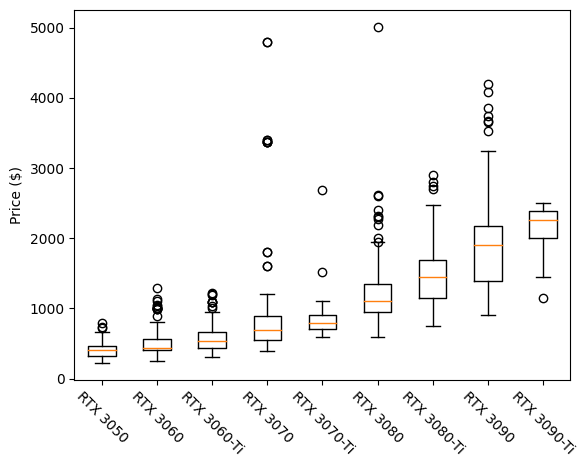

In [96]:
gpu_price_list = [rtx3050['price'], rtx3060['price'], rtx3060ti['price'], rtx3070['price'], rtx3070ti['price'], rtx3080['price'], rtx3080ti['price'], rtx3090['price'], rtx3090ti['price']]
gpu_name = ['RTX 3050', 'RTX 3060', 'RTX 3060-Ti', 'RTX 3070', 'RTX 3070-Ti', 'RTX 3080', 'RTX 3080-Ti', 'RTX 3090', 'RTX 3090-Ti']
gpu_box = plt.boxplot(gpu_price_list, labels=gpu_name)
plt.xticks(rotation=-45)
plt.ylabel('Price ($)')
plt.show()

<span style="color:green">Step 2</span>: Find the outliers according to price.

In [106]:
outliers = [item.get_ydata() for item in r50['fliers']]
gpu_out = {}

c = []

for i in outliers:
    c.append(len(i))

gpu_out['name'] = gpu_name
gpu_out['outliers'] = c

gpu_out


{'name': ['RTX 3050',
  'RTX 3060',
  'RTX 3060-Ti',
  'RTX 3070',
  'RTX 3070-Ti',
  'RTX 3080',
  'RTX 3080-Ti',
  'RTX 3090',
  'RTX 3090-Ti'],
 'outliers': [3, 13, 9, 12, 2, 10, 4, 7, 1]}

In [ ]:
filter = (gpu_box['AVG'] >= Q1 - 1.5 * IQR) & (df['AVG'] <= Q3 + 1.5 *IQR)
df.loc[filter]

####  <ins>**F. Data Preparation**</ins>
>This section will be focused on preparing data into a master dataframe and retrieving gpu launch information.

##### **<span style="color:green">Part 1</span>:** Create a Master DataFrame of All GPU

>With the given dataframes, create a master dataframe that can be accessed later for easier analysis.

<span style="color:green">Step 1</span>: All of the different GPU dataframes have the same shape and column labels, which means that all of the tables can be joined with pd.concat. This is the same as performing a union.

In [10]:
#Creating a master dataframe of all GPU information
gpu_list = [rtx3050, rtx3060, rtx3060ti, rtx3070, rtx3070ti, rtx3080, rtx3080ti, rtx3090, rtx3090ti]
# Concat all the dataframe into one and reorder the index
df = pd.concat(gpu_list, ignore_index = True)

<span style="color:green">Step 2</span>: Create a separate column to label the company of each GPU manufacturer

In [11]:
# Create array to hold company names
companies = []

# Traverse through the names of each GPU and retrieve company names
for val in list(df['name'].items()):
    part = val[1].split(" ")
    companies.append(part[0])

# Add the new column of company names into the second index of the dataframe
df.insert(loc=1, column='company', value=companies)

In [12]:
df

,name,company,model,price,rating,review,link
0,GIGABYTE GeForce RTX 3050 GAMING OC 8G Graphic...,GIGABYTE,RTX 3050,299.99,4.8,88,https://www.newegg.com/gigabyte-geforce-rtx-30...
1,MSI Ventus GeForce RTX 3050 8GB GDDR6 PCI Expr...,MSI,RTX 3050,289.99,4.8,101,https://www.newegg.com/msi-geforce-rtx-3050-rt...
2,MSI Gaming GeForce RTX 3050 8GB GDDR6 PCI Expr...,MSI,RTX 3050,329.99,4.8,39,https://www.newegg.com/msi-geforce-rtx-3050-rt...
3,MSI GeForce RTX 3050 8GB GDDR6 PCI Express 4.0...,MSI,RTX 3050,318.38,5.0,1,https://www.newegg.com/msi-geforce-rtx-3050-rt...
4,GIGABYTE GeForce RTX 3050 EAGLE OC 8G Graphics...,GIGABYTE,RTX 3050,318.00,4.9,22,https://www.newegg.com/gigabyte-geforce-rtx-30...
...,...,...,...,...,...,...,...
1397,GIGABYTE Gaming GeForce RTX 3090 Ti 24GB GDDR6...,GIGABYTE,RTX 3090-Ti,1999.99,0.0,0,https://www.newegg.com/gigabyte-geforce-rtx-30...
1398,ASUS TUF Gaming NVIDIA GeForce RTX 3090 Ti OC ...,ASUS,RTX 3090-Ti,1699.99,0.0,0,https://www.newegg.com/asus-tuf-rtx3090ti-o24g...
1399,ASUS TUF Gaming NVIDIA GeForce RTX 3090 Ti O24...,ASUS,RTX 3090-Ti,1699.99,0.0,0,https://www.newegg.com/asus-geforce-rtx-3090-t...
1400,ASUS TUF Gaming GeForce RTX 3090 Ti 24GB GDDR6...,ASUS,RTX 3090-Ti,1449.99,4.7,34,https://www.newegg.com/asus-geforce-rtx-3090-t...


##### **<span style="color:green">Part 2</span>:** Create DataFrame of GPU Performance and MSRP

>Create a dataframe that holds the GPU name, performance (benchmark score by UserBenchmarks), and MSRP. Information can be obtained from UserBenchmark website.

<span style="color:green">Step 1</span>: Import CSV file of GPU information from UserBenchmarks website. This CSV file has all GPUs ever existed and includes information not useful for this EDA.

* Standard Comparison: Nvidia RTX 2060S ≈ 100%.

In [13]:
gpu_info = pd.read_csv('/Users/yhc/Documents/Coding/EDA/DataAnalyst/GPU_UserBenchmarks.csv', header=0,)

<span style="color:green">Step 2</span>: Clean the data from this csv to only include the 30 series RTX GPUs.

In [37]:
# Select all the 30 series Nvidia GPU in the dataset
rtx30 = gpu_info[(gpu_info['Model'].str.contains('RTX 30')) & (gpu_info['Brand'] == 'Nvidia') & (~gpu_info['Model'].str.contains('Laptop'))]

# Drop the row that is wrong
rtx30.drop(labels=56, axis=0, inplace=True)

# Drop unnecessary columns
rtx30.drop(labels = ['Brand', 'Type', 'Part Number', 'Rank', 'URL'], axis=1, inplace=True)

# Change the column name case to lower
rtx30.columns = rtx30.columns.str.lower()

# Reset the index
rtx30.reset_index(drop=True, inplace=True)


/var/folders/v1/__td9czx4ts4dt0pmkkw0sdh0000gn/T/ipykernel_65824/2900665479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtx30.drop(labels=56, axis=0, inplace=True)
/var/folders/v1/__td9czx4ts4dt0pmkkw0sdh0000gn/T/ipykernel_65824/2900665479.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtx30.drop(labels = ['Brand', 'Type', 'Part Number', 'Rank', 'URL'], axis=1, inplace=True)


<span style="color:green">Step 3</span>: Add MSRP price data for each GPU.

In [38]:
# MSRP of each GPU at launch
msrp = [2000.00, 1500.00, 1200.00, 750.00, 600.00, 500.00, 400.00, 330.00, 250.00]

# Insert a new column for 'msrp' in rtx30
rtx30.insert(loc=3, column='msrp', value = msrp)

In [16]:
rtx30

,model,benchmark,samples,msrp
0,RTX 3090-Ti,266.0,12073,2000.0
1,RTX 3090,233.0,125683,1500.0
2,RTX 3080-Ti,230.0,139549,1200.0
3,RTX 3080,206.0,353788,750.0
4,RTX 3070-Ti,167.0,142865,600.0
5,RTX 3070,154.0,447840,500.0
6,RTX 3060-Ti,132.0,257683,400.0
7,RTX 3060,98.3,232735,330.0
8,RTX 3050,71.7,26735,250.0


####  <ins>**G. Exploratory Data Analysis**</ins>
This section will include all of the exploratory data analysis for this project. All of the DataFrames for each GPU will be created and the analysis of each product will be conducted with the support of data visualizations at the end.

##### **<span style="color:#5DADE2">Analysis 1</span>:** Best GPU for Value

>The prices for GPUs have been inflated by large amount because of cryptocurrency scalpers. However, prices have been dropping more and more and almost has reached MSRP. Compare the current GPU prices to launch MSRP and see which graphics card is most worth for value. 

<span style="color:green">Step 1</span>: Group df by GPU 'model' and plot a boxplot to represent the outliers.

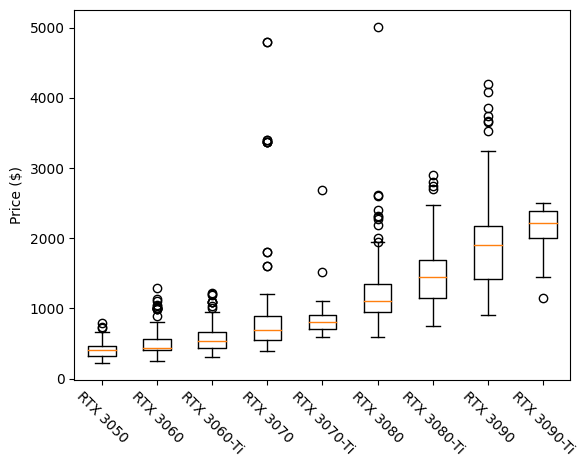

In [17]:
# Group the data by the model type and create a list of all the prices within each group
g = df.groupby('model')['price'].apply(list)

# Create a boxplot of the prices to show outliers
plot = plt.boxplot(g, labels = g.keys())
plt.xticks(rotation=-45)
plt.ylabel('Price ($)')
plt.show()

<span style="color:green">Step 2</span>: Obtain the Lower and Upper bound of useable data given the boxplot above. 
* This is to remove any outliers in the data and find a more accurate average price.

In [57]:
# Find the 1st Quartile for each GPU price
q1 = [round(min(item.get_ydata()), 1) for item in plot['boxes']]
# Find the 3rd Quartile for each GPU price
q3 = [round(max(item.get_ydata()), 1) for item in plot['boxes']]
# Find the Minimum price given the boxplot for each GPU
minimums = [round(item.get_ydata()[0], 1) for item in plot['caps']][::2]
# Find the Maximum price given the boxplot for each GPU
maximums = [round(item.get_ydata()[0], 1) for item in plot['caps']][1::2]

# Initialize an array to hold the lower and upper boundary value for each GPU
lower_out_bound = []
higher_out_bound = []

# Counter
i = 0

# Traverse through the outliers from the boxplot
for item in plot['fliers']:
    # Temporary array to hold the lower and upper boundary value
    item_lower = []
    item_higher = []
    
    # Iterate through each outlier list and distinguish whether they are lower or upper outliers
    for outlier in item.get_ydata():
        # Lower outliers
        if outlier < q1[i]:
            item_lower.append(outlier)
            item_higher.append(maximums[i]+1)

        # Upper outliers
        else:
            item_higher.append(outlier)
            item_lower.append(0)

    # Assign the maximum of the lower outliers to the lower_boundary
    lower_out_bound.append(max(item_lower))
    # Assign the minimum of the upper outliers to the higher_boundary
    higher_out_bound.append(min(item_higher))

    # Increment the counter by 1
    i = i + 1

<span style="color:green">Step 3</span>: Remove the outliers with the boundaries and create a list of average price of each GPU model.

In [54]:
# Initialize an array to hold the average prices
p_mean = []

# Iterate through the GPU prices and remove the outliers
for i in range(len(g)):
    # Create a list of values between low and up boundaries
    p = np.array(list(filter(lambda x: x>lower_out_bound[i] and x<higher_out_bound[i], sorted(g[i]))))
    p_mean.append(p.mean())

# Sort the array in reverse order to fit the data of rtx30
p_mean.sort(reverse=True)


In [58]:
comp_gpu = rtx30.copy()
comp_gpu.insert(loc=4, column='avg_price', value=p_mean)
comp_gpu

,model,benchmark,samples,msrp,avg_price
0,RTX 3090-Ti,266.0,12073,2000.0,2177.053125
1,RTX 3090,233.0,125683,1500.0,1802.072279
2,RTX 3080-Ti,230.0,139549,1200.0,1450.460096
3,RTX 3080,206.0,353788,750.0,1136.528069
4,RTX 3070-Ti,167.0,142865,600.0,825.603929
5,RTX 3070,154.0,447840,500.0,685.757841
6,RTX 3060-Ti,132.0,257683,400.0,550.685419
7,RTX 3060,98.3,232735,330.0,472.112600
8,RTX 3050,71.7,26735,250.0,399.448873
